In [1]:
"""
Just to be sure...

"""
import sys
from jupyter_server import serverapp

print(f"Using python at {sys.executable}")
print(f"Python version {sys.version}")

for server in serverapp.list_running_servers():
    print(server)

Using python at /home/mh19137/.conda/fish/bin/python3.12
Python version 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
{'base_url': '/', 'hostname': 'localhost', 'password': False, 'pid': 741470, 'port': 8080, 'root_dir': '/home/mh19137/fish_test', 'secure': False, 'sock': '', 'token': '652c5a5ab3d642dc8a0b5aea3493c5218082463db9548b9f', 'url': 'http://localhost:8080/', 'version': '2.14.2'}


In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
"""
Load and crop the fish images and masks into memory

"""

import os

import tifffile
import numpy as np
import pandas as pd
from tqdm import tqdm

from dev import image_io
from dev.util import userconf

uconf = userconf()
roi_size = (160, 160, 160)
centres = pd.read_csv("jaw_centres_approx.csv")


def read_mask(n: int) -> np.ndarray:
    """
    Read and crop the mask

    """
    mask_dir = os.path.join(
        uconf["rdsf_dir"], r"1Felix and Rich make models/Training dataset Tiffs/"
    )
    mask_path = os.path.join(mask_dir, f"{n:03}_0000.labels.tif")
    full_mask = tifffile.imread(mask_path)

    centre = centres[centres["n"] == n][["z", "x", "y"]].values[0].astype(int)

    return image_io.crop(full_mask, roi_size, centre)


ns = [69, 70, 89, 90, 93, 97, 488, 489, 491]

masks = [read_mask(n) for n in tqdm(ns)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37it/s]


In [26]:
"""
One of the masks has the skull also labelled... we'll just set this to 0 for now

"""
for mask in masks:
    mask[mask == 2] = 0

In [28]:
"""
Also read in the original CT scans (this takes a while)

"""


def read_scan(n: int) -> np.ndarray:
    """
    Read and crop the scan

    """
    full_scan = image_io.read_tiffstack(n)

    centre = centres[centres["n"] == n][["z", "x", "y"]].values[0].astype(int)

    return image_io.crop(full_scan, roi_size, centre)


scans = [read_scan(n) for n in tqdm(ns)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [14:39<00:00, 97.71s/it]


In [62]:
"""
Turn these into Subjects, and create a SubjectsDataset from them with the appropriate transforms

"""

import torchio as tio

transform = image_io.random_transforms()

subjects = [
    image_io.subject(i.astype(np.float64), m.astype(np.float64))
    for i, m in zip(scans, masks)
]

subjectdataset = image_io.subject_dataset(subjects, transform=transform)

# This is slow and bad
indices = np.arange(len(subjectdataset))
np.random.shuffle(indices)
train_idx, val_idx, test_idx = np.split(
    indices, [int(0.8 * len(indices)), len(indices) - 1]
)
print(train_idx, val_idx, test_idx)

train_data = tio.SubjectsDataset([subjectdataset[i] for i in train_idx])
val_data = tio.SubjectsDataset([subjectdataset[i] for i in val_idx])
test_data = subjectdataset[test_idx]

del subjectdataset

len(train_data), len(val_data), len(test_data)

uint8
[7 6 1 0 5 8 3] [4] [2]


ValueError: object __array__ method not producing an array

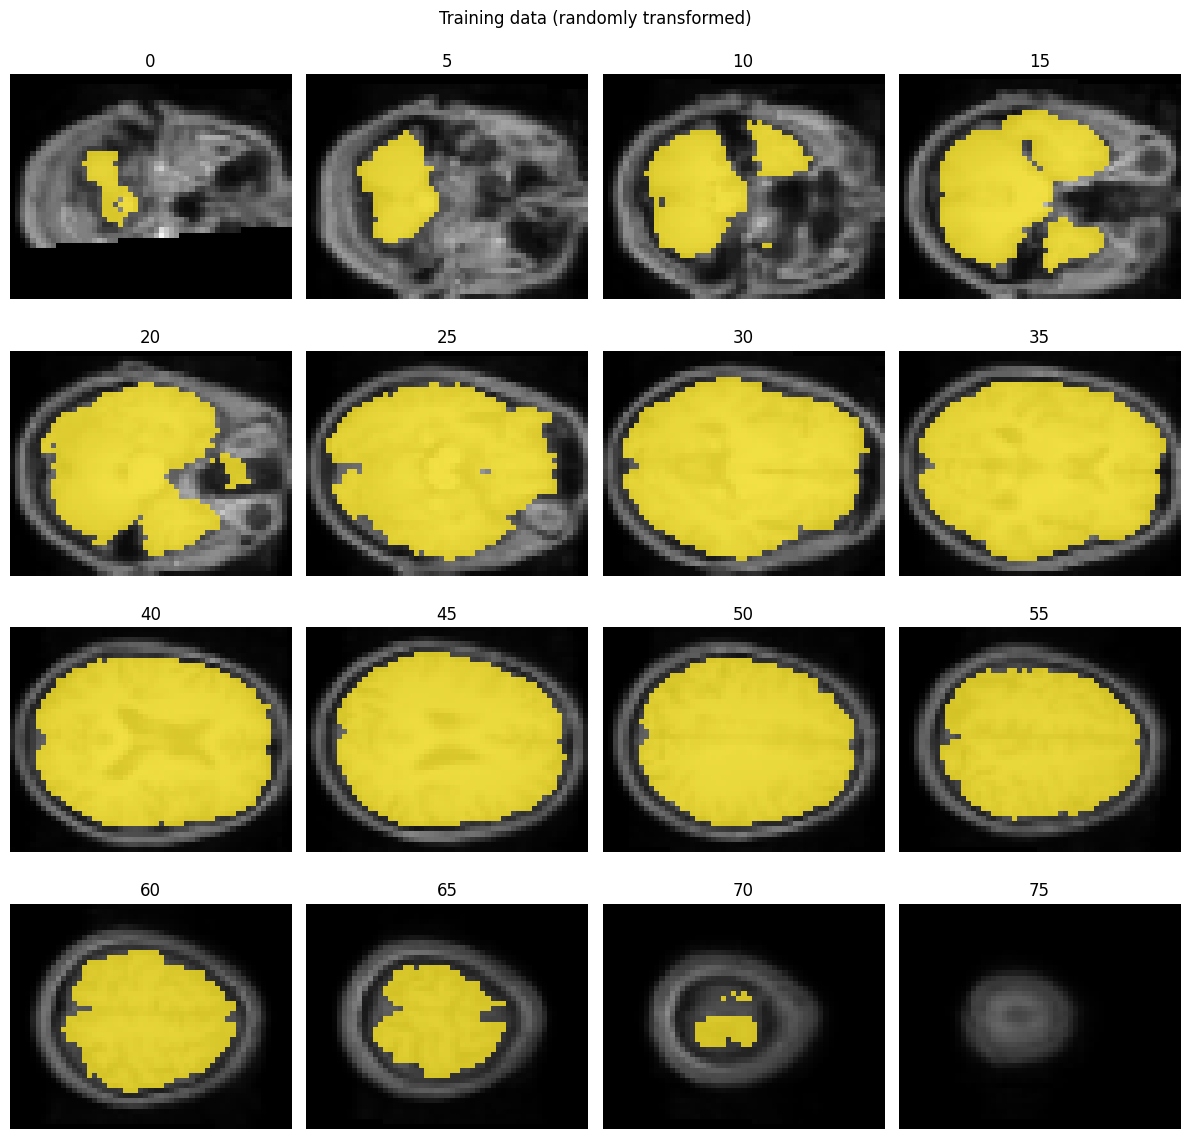

In [4]:
from dev import plot

fig, _ = plot.plot_arr(
    image_io.pytorch2img(train_data[0].image.data.squeeze()),
    image_io.pytorch2img(train_data[0].label.data.squeeze()),
)
fig.suptitle("Training data (randomly transformed)")
fig.tight_layout()

In [5]:
""" Create a DataLoader"""

from typing import Union

import torch
patch_size = [int(x) for x in uconf["patch_size"].split(",")]
print(f"Patch size: {patch_size}")


def dataloader(
    dataset: Union[tio.SubjectsDataset, tio.Subject], *, mode: str
) -> tuple[torch.utils.data.DataLoader, Union[tio.Queue, tio.GridSampler]]:
    """
    Create a dataloader for our data

    """
    if mode not in {"train", "val", "test"}:
        raise ValueError(f"Invalid mode: {mode}")

    # We want the training and validation to occur on random patches
    if mode in {"train", "val"}:
        if not isinstance(dataset, tio.SubjectsDataset):
            raise ValueError(
                "For training and validation, a SubjectsDataset is required"
            )

        # Choose the probability of patches being centred on each value
        label_probs = {0: 1, 1: 1, 2: 1}
        patch_sampler = tio.LabelSampler(
            patch_size=patch_size, label_probabilities=label_probs
        )

        patches = tio.Queue(
            dataset,
            max_length=10000,
            samples_per_volume=6,
            sampler=patch_sampler,
            num_workers=10,
        )

    else:
        if not isinstance(dataset, tio.Subject):
            raise ValueError("For testing, a Subject is required")

        # For testing, we want to evaluate on the whole image
        patches = tio.GridSampler(dataset, patch_size, patch_overlap=(4, 4, 4))

    loader = torch.utils.data.DataLoader(
        patches,
        batch_size=uconf["batch_size"],
        shuffle=False,
        num_workers=0,  # i think this should be 0 for training data, since the patches are already loaded
        pin_memory=torch.cuda.is_available(),
    )

    return loader, patches


train_loader, _ = dataloader(train_data, mode="train")
val_loader, _ = dataloader(val_data, mode="val")
test_loader, grid_sampler = dataloader(test_data, mode="test")

Patch size: [32, 32, 32]


In [6]:
"""
Load a model

"""

from dev.segmentation import model as lib_model

model = lib_model.model()
# lib_model.draw_model(model, "model.pdf")

In [7]:
"""
Create an optimiser + choose a loss function

"""

from monai.losses import TverskyLoss

optimiser = lib_model.optimiser(model)
loss = TverskyLoss(include_background=True, to_onehot_y=True, alpha=0.2)

optimiser

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5e-05
    maximize: False
    weight_decay: 0
)

In [8]:
import warnings
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    # Yellow text
    yellow = "\033[33m"
    clear = "\033[0m"
    warnings.warn(f"{yellow}This might not be what you want!{clear}")
print(f"Using {device} device")

_ = model.to(device)

Using cuda device


In [10]:
model, train_loss, val_loss = lib_model.train(
    model,
    optimiser,
    loss,
    train_loader,
    val_loader,
    device=device,
    epochs=5,
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=2),
    notebook=True
)

  0%|                                                                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

 20%|█████████████████████████████████████████████████                                                                                                                                                                                                    | 1/5 [00:29<01:56, 29.16s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 2/5 [00:58<01:27, 29.30s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 3/5 [01:28<00:58, 29.42s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4/5 [01:57<00:29, 29.43s/it]

Training:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/22 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:27<00:00, 29.48s/it]


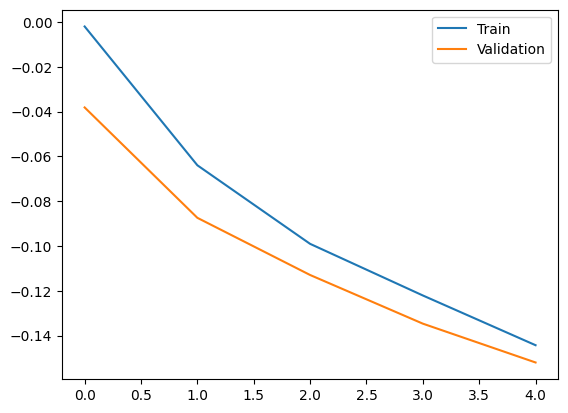

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()

In [12]:
"""
Show the result on the test data

"""

agg_kw = {"sampler": grid_sampler, "overlap_mode": "crop"}
pred_aggregator = tio.inference.GridAggregator(**agg_kw)
img_aggregator = tio.inference.GridAggregator(**agg_kw)
truth_aggregator = tio.inference.GridAggregator(**agg_kw)

# Our image is smaller than 1 batch, so we can just do it all at once
batch = []
locations = []
truth = []
for patch in grid_sampler:
    gpu_patch = patch[tio.IMAGE][tio.DATA].to(device).unsqueeze(0)
    truth_patch = patch[tio.LABEL][tio.DATA].unsqueeze(0)

    locations.append(patch[tio.LOCATION])
    batch.append(gpu_patch)
    truth.append(truth_patch)

batch_tensor = torch.cat(batch, dim=0)
truth_tensor = torch.cat(truth, dim=0)
locations_tensor = torch.stack(locations)
patch_pred = model(batch_tensor).to("cpu").detach()

pred_aggregator.add_batch(patch_pred, locations=locations_tensor)
img_aggregator.add_batch(batch_tensor, locations=locations_tensor)
truth_aggregator.add_batch(truth_tensor, locations=locations_tensor)

prediction = pred_aggregator.get_output_tensor()[1].numpy()
image = img_aggregator.get_output_tensor()[0].numpy()
truth = truth_aggregator.get_output_tensor()[0].numpy()

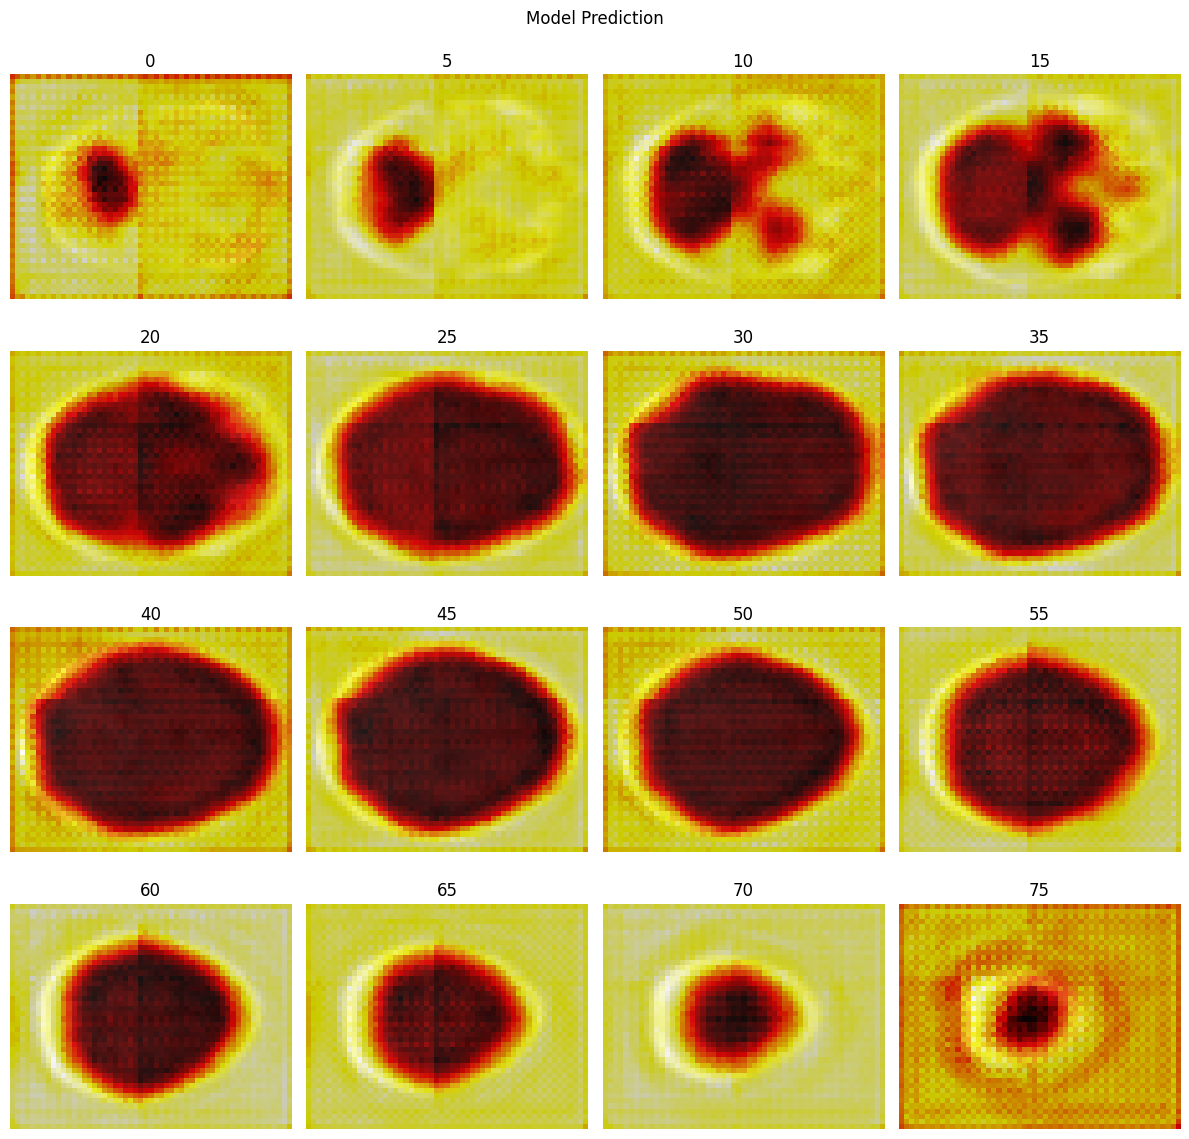

In [13]:
fig, axis = plot.plot_arr(image, prediction)
fig.suptitle("Model Prediction")
fig.tight_layout()

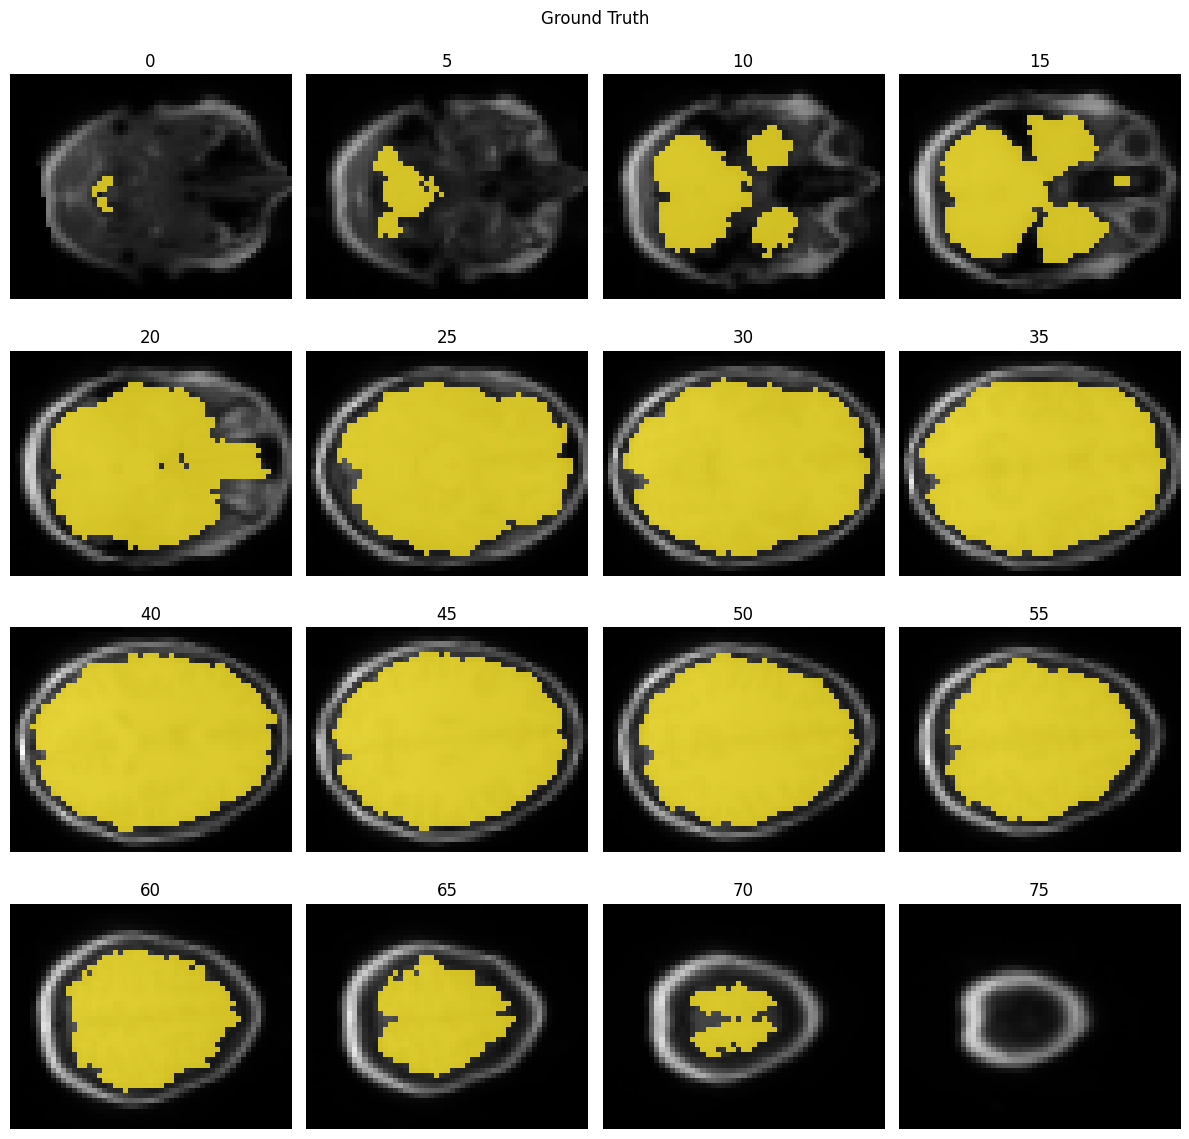

In [14]:
fig, axis = plot.plot_arr(image, truth)
fig.suptitle("Ground Truth")
fig.tight_layout()

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '5'}>,
         <Axes: title={'center': '10'}>, <Axes: title={'center': '15'}>],
        [<Axes: title={'center': '20'}>, <Axes: title={'center': '25'}>,
         <Axes: title={'center': '30'}>, <Axes: title={'center': '35'}>],
        [<Axes: title={'center': '40'}>, <Axes: title={'center': '45'}>,
         <Axes: title={'center': '50'}>, <Axes: title={'center': '55'}>],
        [<Axes: title={'center': '60'}>, <Axes: title={'center': '65'}>,
         <Axes: title={'center': '70'}>, <Axes: title={'center': '75'}>]],
       dtype=object))

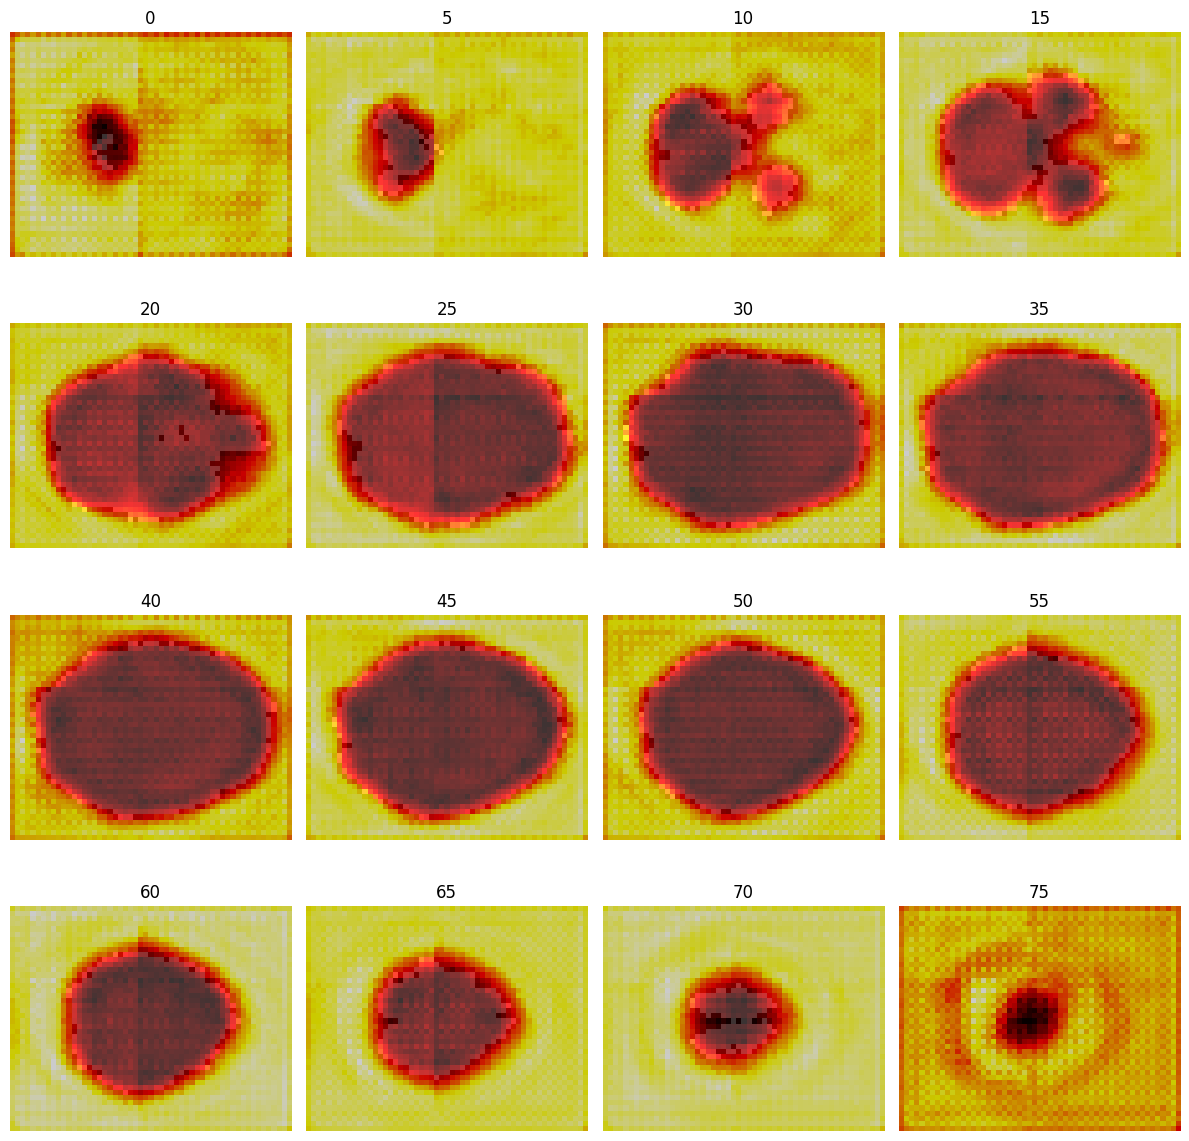

In [15]:
plot.plot_arr(truth, prediction)